# Projet BIG DATA Rémi Lambert - IUEM 2019
## Oscillations Australes

In [63]:
import os
import numpy as np
import xarray as xr , dask
import matplotlib.pyplot as plt
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap as bm
# import pandas as pd

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns
import intake

## Load data

In [64]:
ds = xr.open_zarr('ncep1_slp_hem_south.zarr')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 144, time: 102272)
Coordinates:
  * lat      (lat) float32 0.0 -2.5 -5.0 -7.5 -10.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 ... 2017-12-31T18:00:00
Data variables:
    slp      (time, lat, lon) float32 dask.array<shape=(102272, 37, 144), chunksize=(1460, 37, 144)>
Attributes:
    Conventions:    COARDS
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    history:        created 99/05/11 by Hoop (netCDF2.3)\nConverted to chunke...
    platform:       Model
    title:          4x daily NMC reanalysis (1948)


In [65]:
#moyenne mensuelle
ds=ds.resample(time='1M').mean()
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 144, time: 840)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2017-12-31
  * lat      (lat) float32 0.0 -2.5 -5.0 -7.5 -10.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    slp      (time, lat, lon) float32 dask.array<shape=(840, 37, 144), chunksize=(1, 37, 144)>


## Remove the seasonal cycle
(valeur-valeur moyenne du mois)

In [66]:
climatology = ds.groupby('time.month').mean('time')

ds['slp_ano']= ds['slp'].groupby('time.month') - climatology['slp']
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 144, time: 840)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2017-12-31
  * lat      (lat) float32 0.0 -2.5 -5.0 -7.5 -10.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slp      (time, lat, lon) float32 dask.array<shape=(840, 37, 144), chunksize=(1, 37, 144)>
    slp_ano  (time, lat, lon) float32 dask.array<shape=(840, 37, 144), chunksize=(840, 37, 144)>


In [67]:
#creation du features(lon,lat), time correspond au sample
ds=ds.stack(features=['lon','lat'])
print(ds)

<xarray.Dataset>
Dimensions:   (features: 5328, time: 840)
Coordinates:
  * time      (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2017-12-31
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * features  (features) MultiIndex
  - lon       (features) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  - lat       (features) float64 0.0 -2.5 -5.0 -7.5 ... -65.0 -67.5 -70.0 -72.5
Data variables:
    slp       (time, features) float32 dask.array<shape=(840, 5328), chunksize=(1, 5328)>
    slp_ano   (time, features) float32 dask.array<shape=(840, 5328), chunksize=(840, 5328)>


## Normalization

In [68]:
X=ds.slp_ano

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# Normalize data:

Xn=scaler.transform(X)
ds['slp_norm'] = xr.DataArray(Xn, dims=['time','features'])
ds.slp_norm.shape
print(ds)

<xarray.Dataset>
Dimensions:   (features: 5328, time: 840)
Coordinates:
  * features  (features) MultiIndex
  - lon       (features) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  - lat       (features) float64 0.0 -2.5 -5.0 -7.5 ... -65.0 -67.5 -70.0 -72.5
  * time      (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2017-12-31
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slp       (time, features) float32 dask.array<shape=(840, 5328), chunksize=(1, 5328)>
    slp_ano   (time, features) float32 dask.array<shape=(840, 5328), chunksize=(840, 5328)>
    slp_norm  (time, features) float32 -0.108277865 -0.18743016 ... -0.45694748


## Reduction

In [69]:
Xo=ds.slp_norm

maxvar = 99.9

# Compute P (the EOFs) from x:
reducer = PCA(n_components=maxvar/100,svd_solver='full')
reducer.fit(Xo)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xo) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))
print(Xr.shape)

(840, 396)


## Clustering with KMeans

In [70]:
from sklearn.cluster import KMeans

n_clusters=2

# Create the classifier:
kmeans = KMeans(n_clusters, random_state=0)

# Train the classifier:
kmeans.fit(Xr)

# Classify the dataset:
labels = kmeans.predict(Xr)
ds['Labels']=xr.DataArray(labels,dims=['time'])

#
n_clusters_ = kmeans.n_clusters
print("Cluster centers shape:",kmeans.cluster_centers_.shape)
print("Cluster centers:\n",kmeans.cluster_centers_)
print(ds)

Cluster centers shape: (2, 396)
Cluster centers:
 [[-2.52386036e+01 -1.15003395e+00 -7.39879608e-01  5.80838561e-01
  -2.46736273e-01  3.87288332e-01  3.03464115e-01 -2.27508843e-01
  -1.45337507e-01 -6.46843836e-02  5.62299788e-01 -8.14841166e-02
   1.38143256e-01  1.27728820e-01 -1.74273215e-02 -1.60657614e-01
   9.80077758e-02 -1.16405115e-02 -8.99246484e-02  1.38511017e-01
   2.42953926e-01  2.12755818e-02 -7.39552006e-02  1.01740852e-01
   6.22557476e-02  7.92106614e-03  1.79930374e-01  3.45326550e-02
  -2.47056484e-02 -9.01021156e-03 -5.39560877e-02  5.99443959e-03
  -1.57746226e-02 -1.99231021e-02 -2.97831167e-02  1.85152903e-01
  -7.20878914e-02  1.55923096e-02 -5.53097129e-02 -5.07927127e-02
  -8.48472640e-02  4.02457491e-02  1.39667243e-01 -1.64895952e-02
  -1.10754315e-02 -1.00404233e-01 -1.37420101e-02 -4.53125359e-03
  -6.98530972e-02  3.85378227e-02  4.33326811e-02  6.98363855e-02
  -4.62163799e-02 -8.45210254e-03  1.73107330e-02  1.99870132e-02
  -8.25995952e-02  2.51976

In [71]:
class0 = np.zeros((sum(labels == 0),len(Xr[1])))
class1 = np.zeros((sum(labels == 1),len(Xr[1])))

In [75]:
lab0 = ds.where(ds['Labels']==0, drop=True).unstack('features')
lab1 = ds.where(ds['Labels']==1, drop=True).unstack('features')
print(lab0, lab1)

<xarray.Dataset>
Dimensions:   (lat: 37, lon: 144, time: 495)
Coordinates:
  * time      (time) datetime64[ns] 1948-05-31 1949-04-30 ... 2017-12-31
    month     (time) int64 5 4 5 6 11 1 6 3 1 2 6 9 ... 12 2 3 4 5 6 7 8 9 11 12
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat       (lat) float64 0.0 -2.5 -5.0 -7.5 -10.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    slp       (time, lon, lat) float32 dask.array<shape=(495, 144, 37), chunksize=(1, 144, 37)>
    slp_ano   (time, lon, lat) float32 dask.array<shape=(495, 144, 37), chunksize=(495, 144, 37)>
    slp_norm  (time, lon, lat) float32 0.49483827 0.57548034 ... -0.45694748
    Labels    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 <xarray.Dataset>
Dimensions:   (lat: 37, lon: 144, time: 345)
Coordinates:
  * time      (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2017-10-31
    month     (time) int64 1 2 3 4 6 7 8 9 10 11 12 ... 7 11 11 12 8 9 9 11 1 10
  * lon       (l

In [79]:
slp_clus0 = lab0.mean(dim='time')
slp_clus1 = lab1.mean(dim='time')

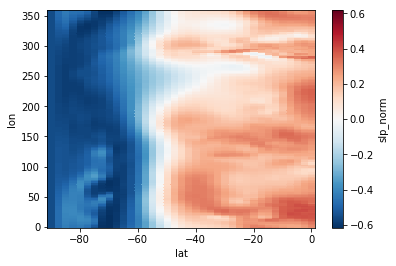

In [81]:
slp_clus0['slp_norm'].plot()

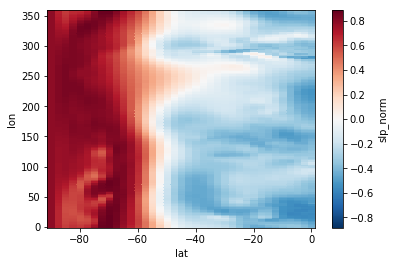

In [82]:
slp_clus1['slp_norm'].plot()